# Welcome to the Neural Network assisted sleep state classifier!

### This notebook walks us through some features of the dataset, visualizations, and model evaluation



In [ ]:
print("Hello World")

In [23]:
import tensorflow as tf
from tensorflow import keras
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
import os
from numpy import genfromtxt
from datetime import datetime
import random
from sklearn.model_selection import train_test_split ##Need to randomly split data
from main import CONFIG_PATH

from functions.hypnogram_postprocess import postProcessHypnogram
from functions.helper_functions import *
from sklearn.preprocessing import normalize
from operator import itemgetter


#from keras.layers import Embedding,  LSTM
from main import CONFIG_PATH
config = load_config(CONFIG_PATH / "my_config.yaml")
globals().update(config)



## Specify demo directory

In [30]:
# Specify demo directory
WORKING_DIR = "G:/sleep_DNN/data"
SESSION_ID = "02-25"
currentModel = WORKING_DIR + "/model_hypnogram"



## Load Train and Test Data

Data is comprised of 28 hours at 2Hz, hence a size of 201600

In [132]:
def loadInputData(filename):
    DATA_DIR = WORKING_DIR + filename
    LABEL_DIR = DATA_DIR.replace('_data.csv', '_labels.csv')
    print('Loaded labels for: ' + filename)
    print(DATA_DIR)
    
    ## Now, call pandas and load data
    train_data = pd.read_csv(DATA_DIR, header=None, delimiter=',').to_numpy()
    train_labels = pd.read_csv(LABEL_DIR, header=None, delimiter=',').to_numpy()
    
    return train_data, train_labels
    
filename = '/model_spectrogram_' + SESSION_ID + '_data.csv'
train_data, train_labels = loadInputData(filename)

hypnogramOrig = onehot_to_array(train_labels)
hypTimeAxis = np.linspace(1/hypFs, len(hypnogramOrig)/hypFs, len(hypnogramOrig))
print('Here are the shapes of our dataset')
print('Data: ' + str(train_data.shape))
print('Labels: ' + str(train_labels.shape))
print(train_data[:10,:])
print(train_labels[:10,:])

## For the demo, cut data to the 6 - 18 hours of continuous data
print("Slicing data...")
#train_data, train_labels = train_data[0:3600*12*2+3600*6*2,:], train_labels[0:3600*12*2+3600*6*2,:]
hypnogramOrig = onehot_to_array(train_labels)
hypTimeAxis = np.linspace(1/hypFs, len(hypnogramOrig)/hypFs, len(hypnogramOrig))
print('Here are NEW the shapes of our dataset')
print('Data: ' + str(train_data.shape))
print('Labels: ' + str(train_labels.shape))
print(train_data[:10,:])
print(train_labels[:10,:])

dfLabels = pd.Categorical(hypnogramOrig, categories=['Awake','Unc', 'NREM', 'REM'])

Loaded labels for: /model_spectrogram_02-25_data.csv
G:/sleep_DNN/data/model_spectrogram_02-25_data.csv
Here are the shapes of our dataset
Data: (201600, 319)
Labels: (201600, 4)
[[0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [6.8858 7.5332 7.8917 ... 4.5304 4.6347 4.7837]
 [6.896  7.5042 7.8894 ... 4.5653 4.674  4.8218]]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]]
Slicing data...
Here are NEW the shapes of our dataset
Data: (201600, 319)
Labels: (201600, 4)
[[0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 [0.     0.     0.     ... 0.     0.     0.    ]
 ...
 [0.     0.     0.     ... 0.     0.     0.    ]
 [6.8858 7.5332 7.8917 ... 4.5304 4.6347 4.7837]
 [6.896  7.5042 7.8894 ... 4.5653 4.674  4.8218]]
[[1 0 0 0]
 [1 

## Let's take a look at the label distribution as well as the features across time

### First 318 features are from the neural signal while the final feature contains movement information

Text(0.5, 1.0, 'Hypnogram')

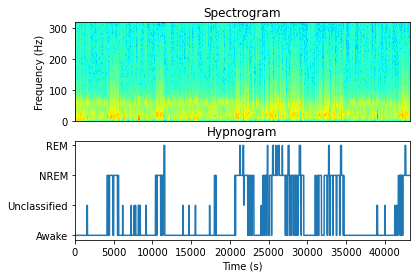

In [61]:
## PLot only the frequency specific information

plt.figure();
plt.subplot(211);
plt.imshow(np.transpose(train_data[:,0:318]), aspect='auto', origin='lower',cmap='jet')
plt.xticks([]);
plt.ylabel('Frequency (Hz)');
plt.title('Spectrogram');


plt.subplot(212);
plt.plot(hypTimeAxis, hypnogramOrig);
plt.yticks(ticks=[0,1,2,3], labels=['Awake', 'Unclassified', 'NREM', 'REM']);
plt.xlabel('Time (s)');
plt.xlim([0,max(hypTimeAxis)]);
plt.title('Hypnogram')

### We can see that the REM states occur less often than the NREM and Awake states


In [133]:
stateLabels = ['Awake', 'Unclassified', 'NREM', 'REM']
dfHypnogram = [stateLabels[i] for i in hypnogramOrig]
dfLabels = pd.Categorical(dfHypnogram)
dfLabels.describe()


,counts,freqs
categories,,
Awake,109182,0.541577
NREM,77243,0.383150
REM,10577,0.052465
Unclassified,4598,0.022808


# Designing Neural Network Architecture

In [134]:

## Batch normalazition 
model = keras.Sequential()

model.add(keras.layers.Dense(10,activation='relu', input_shape=(319,)))
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(12, activation='relu'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(4, activation='softmax',input_shape=(4,)))

model.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['accuracy', 'categorical_accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 10)                3200      
_________________________________________________________________
dense_23 (Dense)             (None, 64)                704       
_________________________________________________________________
batch_normalization_16 (Batc (None, 64)                256       
_________________________________________________________________
dense_24 (Dense)             (None, 256)               16640     
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
dense_25 (Dense)             (None, 256)               65792     
_________________________________________________________________
batch_normalization_18 (Batc (None, 256)               1024      
__________

## Begin training the Neural Network

Data will be randomly 80-20 split over 10 folds for better generalization. Since REM states are the minority class, we downsample the majority class to accommodate. There are future plans to implement SMOTE for minority class upsampling.

In [103]:
## Techniques to rebalance the data would be either downsaampling the majority class or artificially 
## resampling the minority class using SMOTE. Current method is simply downsampling
def rebalanceData(x_train, y_train):
    ##Check class distribution
    storeAllocated = []
    x_out = np.empty((0,319))
    y_out = np.empty((0,4))
    [print("s" + str(s) + ":" +  str(len(np.argwhere(y_train[:,s] == 1)))) for s in range(0,4)]

    for s in range(0,4):
        toExtract = np.argwhere(y_train[:,s] == 1).flatten()
        storeAllocated.append(toExtract)#y_train[toExtract,])
    minNum = len(storeAllocated[3])
    
    ##For Awake, NREM, and REM. For unclassified, append as is, or remove half
    for s in [0,2,3]:
        toAllocate = random.sample([storeAllocated[s][i] for i in range(0,len(storeAllocated[s]))], minNum)
        x_out = np.append(x_out, np.array(x_train[toAllocate,:]), axis=0)
        y_out = np.append(y_out, np.array(y_train[toAllocate,:]), axis=0)
        
    x_out = np.append(x_out, np.array(x_train[storeAllocated[1],:]), axis=0)
    y_out = np.append(y_out, np.array(y_train[storeAllocated[1],:]), axis=0)
    
    return x_out, y_out




In [142]:
acc, val_acc, loss,val_loss = [],[],[],[]
    

## Running k-folds classification to improve generalization and reduce overfitting
for i in range(0,10):

    ##Only need to balance the training data, not the validation data.
    x_train, x_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.2, shuffle= True)
    x_train, y_train = rebalanceData(x_train, y_train) ##Utilize a form of downsampling rather than synthetic data
    history = model.fit(x_train, y_train, batch_size=900, epochs=100, validation_data=(x_valid, y_valid), verbose=0)#, callbacks=[lrs])

    # acc.append(history.history['accuracy'])
    # val_acc.acc(history.history['val_accuracy'])
    acc.append(history.history['acc'])
    val_acc.append(history.history['val_acc'])
    loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    print('Acc: {} - loss {}'.format(round(history.history['acc'][0],2), round(history.history['loss'][0],2)))
    print('Val acc: {} - Val loss {}'.format(round(history.history['val_acc'][0],2), round(history.history['val_loss'][0],2)))

print("Finished model fitting")

s0:87267
s1:3716
s2:61851
s3:8446
Acc: 0.9 - loss 0.3
Val acc: 0.68 - Val loss 1.1
s0:87352
s1:3709
s2:61778
s3:8441
Acc: 0.9 - loss 0.28
Val acc: 0.86 - Val loss 0.46
s0:87412
s1:3665
s2:61760
s3:8443
Acc: 0.91 - loss 0.27
Val acc: 0.83 - Val loss 0.63
s0:87342
s1:3698
s2:61749
s3:8491
Acc: 0.91 - loss 0.25
Val acc: 0.78 - Val loss 0.77
s0:87445
s1:3680
s2:61798
s3:8357
Acc: 0.91 - loss 0.26
Val acc: 0.85 - Val loss 0.55
s0:87394
s1:3645
s2:61811
s3:8430
Acc: 0.92 - loss 0.24
Val acc: 0.81 - Val loss 0.63
s0:87365
s1:3644
s2:61797
s3:8474
Acc: 0.92 - loss 0.24
Val acc: 0.79 - Val loss 0.71
s0:87375
s1:3651
s2:61775
s3:8479
Acc: 0.92 - loss 0.25
Val acc: 0.87 - Val loss 0.44
s0:87437
s1:3713
s2:61726
s3:8404
Acc: 0.92 - loss 0.23
Val acc: 0.79 - Val loss 0.72
s0:87333
s1:3721
s2:61808
s3:8418
Acc: 0.92 - loss 0.23
Val acc: 0.84 - Val loss 0.51
Finished model fitting


Acc: 0.88 - loss 0.33
Val acc: 0.8 - Val loss 0.54


# Plot Loss and accuracy

In [143]:
print("Starting prediction...")
predictedHypnogram = model.predict(train_data)
# Serialize model to JSON
predictedHypnogram = np.array(predictedHypnogram)
    
print("Starting post-processing...this may take a while")
newPredict, newProbVal = postProcessHypnogram(predictedHypnogram)




Starting prediction...
Starting post-processing...this may take a while


In [144]:
acc_all = np.array(acc).flatten().tolist()
valacc_all = np.array(val_acc).flatten().tolist()
loss_all = np.array(loss).flatten().tolist()
valloss_all = np.array(val_loss).flatten().tolist()
epochs = range(len(acc_all))


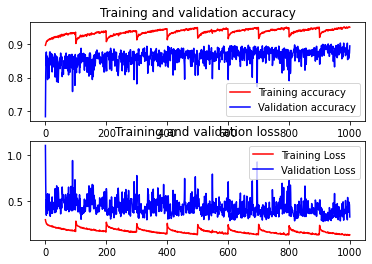

In [145]:
# Plot evaluations
plt.figure()
plt.subplot(211)
plt.plot(epochs, acc_all, 'r', label='Training accuracy')
plt.plot(epochs, valacc_all, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.subplot(212)
plt.plot(epochs, loss_all, 'r', label='Training Loss')
plt.plot(epochs, valloss_all, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.show()



# Summary

The model is overfitting in this example due to only being trained on one dataset. However, recordings from multiple days and animals were included for the neural network deployed in my lab pipeline. 

Some future steps would be a recurrent neural network due to the temporal dependency of the dataset. For example, if one label is NREM, it is probabilistically more likely for the previous and next states to be NREM as well, since transition states are rare in the overall data. 